# Variational AutoEncoders

Full Name: Mohammad Erfan Bagherinejad

Student ID: 402200359


# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and a conditional variational autoencoder with slightly different architectures and apply them to the popular MNIST handwritten dataset.

Load several useful packages that are used in this notebook:

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import random
import cv2
import matplotlib as mpl
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [4]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load MNIST Dataset


VAEs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset.

In [5]:
batch_size = 32

mnist_train = datasets.MNIST('./data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.15MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Visualize dataset

It is always a good idea to look at examples from the dataset before working with it. Let's visualize the digits in the MNIST dataset. We have defined the function `show_images` to visualize the images.


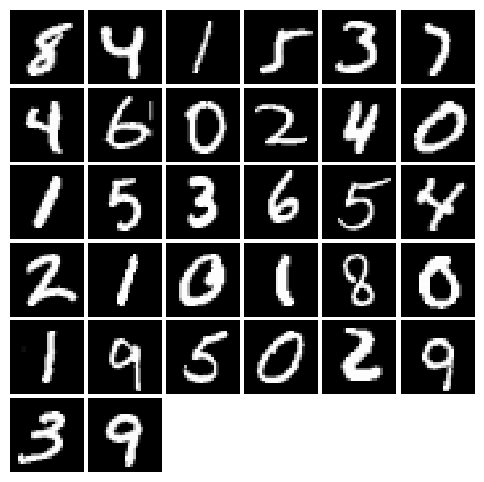

In [6]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

data_iter = iter(loader_train)
imgs, _ = next(data_iter)
imgs = imgs.view(batch_size, 784)
show_images(imgs)

# Fully Connected VAE

Your first VAE implementation will consist solely of fully connected layers. You'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. In this section you'll define the Encoder and Decoder models in the VAE class and implement the reparametrization trick, forward pass, and loss function to train your first VAE.

## FC-VAE Forward

Complete the VAE class by writing the initialization and the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.



In [7]:
class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar

## Loss Function

Complete the vae_loss function below

In [97]:
def vae_loss(recon, data, mu, logvar):
    """
    Computes the loss for a Variational Autoencoder.

    Args:
        recon (Tensor): The reconstructed output from the decoder.
        data (Tensor): The original input data.
        mu (Tensor): The mean vector from the encoder.
        logvar (Tensor): The log variance vector from the encoder.

    Returns:
        Tensor: The total loss as the sum of reconstruction and KL divergence losses.
    """
    # Reconstruction loss (binary cross-entropy for normalized inputs)
    recon_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    # KL divergence for a Gaussian is: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total lossloss = reconstruction_loss + kl_divergence + 
    total_loss = recon_loss + kl_loss

    return total_loss



## Train a model

Now that we have our VAE defined and loss function ready, lets train our model!

Complete the train_vae_mlp function to train the network.

In [98]:
from tqdm import tqdm
def train_vae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    """
    Trains the VAE_MLP model on the provided data.

    Args:
        model (VAE_MLP): The VAE model to train.
        train_loader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of epochs for training.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        None
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []
        
        # Wrap train_loader with tqdm to show progress
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
            # Move data to the device
            data = data.to(device)

            # Flatten the input data
            data = data.view(data.size(0), -1)

            # Forward pass
            recon, mu, logvar = model(data)

            # Calculate the loss
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store the loss for this batch
            total_loss.append(loss.item())

        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f'VAE- Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}')

In [124]:
# Define parameters
input_dim = 784  # Assuming the input is MNIST images (28x28 pixels)
hidden_dim = 512  # Size of hidden layers in the encoder and decoder
latent_size = 20  # Dimensionality of the latent space

# Initialize the VAE model
VAE = VAE_MLP(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_size)

# Assuming loader_train is already defined and contains the training data
train_vae_mlp(VAE, loader_train, num_epochs=50, learning_rate=1e-3)


Epoch 1/50: 100%|██████████| 1875/1875 [00:08<00:00, 209.01it/s]


VAE- Epoch [1/50], Loss: 4581.028672395833



Epoch 2/50: 100%|██████████| 1875/1875 [00:09<00:00, 203.71it/s]


VAE- Epoch [2/50], Loss: 3713.103578125



Epoch 3/50: 100%|██████████| 1875/1875 [00:09<00:00, 201.69it/s]


VAE- Epoch [3/50], Loss: 3571.7415404947915



Epoch 4/50: 100%|██████████| 1875/1875 [00:08<00:00, 209.62it/s]


VAE- Epoch [4/50], Loss: 3489.0513123697915



Epoch 5/50: 100%|██████████| 1875/1875 [00:08<00:00, 210.82it/s]


VAE- Epoch [5/50], Loss: 3426.915041015625



Epoch 6/50: 100%|██████████| 1875/1875 [00:08<00:00, 209.39it/s]


VAE- Epoch [6/50], Loss: 3385.71349765625



Epoch 7/50: 100%|██████████| 1875/1875 [00:09<00:00, 204.89it/s]


VAE- Epoch [7/50], Loss: 3356.623819661458



Epoch 8/50: 100%|██████████| 1875/1875 [00:08<00:00, 210.08it/s]


VAE- Epoch [8/50], Loss: 3333.2724475260416



Epoch 9/50: 100%|██████████| 1875/1875 [00:08<00:00, 208.95it/s]


VAE- Epoch [9/50], Loss: 3316.2127755208335



Epoch 10/50: 100%|██████████| 1875/1875 [00:09<00:00, 204.92it/s]


VAE- Epoch [10/50], Loss: 3300.6184040364583



Epoch 11/50: 100%|██████████| 1875/1875 [00:08<00:00, 211.11it/s]


VAE- Epoch [11/50], Loss: 3288.128751171875



Epoch 12/50: 100%|██████████| 1875/1875 [00:08<00:00, 209.29it/s]


VAE- Epoch [12/50], Loss: 3275.9100979166665



Epoch 13/50: 100%|██████████| 1875/1875 [00:08<00:00, 210.36it/s]


VAE- Epoch [13/50], Loss: 3265.7997376302083



Epoch 14/50: 100%|██████████| 1875/1875 [00:09<00:00, 202.12it/s]


VAE- Epoch [14/50], Loss: 3258.177105078125



Epoch 15/50: 100%|██████████| 1875/1875 [00:08<00:00, 213.61it/s]


VAE- Epoch [15/50], Loss: 3249.9292481770835



Epoch 16/50: 100%|██████████| 1875/1875 [00:09<00:00, 206.49it/s]


VAE- Epoch [16/50], Loss: 3242.9841501302085



Epoch 17/50: 100%|██████████| 1875/1875 [00:09<00:00, 204.71it/s]


VAE- Epoch [17/50], Loss: 3237.672983854167



Epoch 18/50: 100%|██████████| 1875/1875 [00:08<00:00, 211.32it/s]


VAE- Epoch [18/50], Loss: 3231.6180256510415



Epoch 19/50: 100%|██████████| 1875/1875 [00:08<00:00, 211.58it/s]


VAE- Epoch [19/50], Loss: 3223.813748828125



Epoch 20/50: 100%|██████████| 1875/1875 [00:08<00:00, 212.25it/s]


VAE- Epoch [20/50], Loss: 3220.12205078125



Epoch 21/50: 100%|██████████| 1875/1875 [00:09<00:00, 204.50it/s]


VAE- Epoch [21/50], Loss: 3215.2413682291667



Epoch 22/50: 100%|██████████| 1875/1875 [00:09<00:00, 208.10it/s]


VAE- Epoch [22/50], Loss: 3210.35611328125



Epoch 23/50: 100%|██████████| 1875/1875 [00:08<00:00, 209.96it/s]


VAE- Epoch [23/50], Loss: 3206.1890498697917



Epoch 24/50: 100%|██████████| 1875/1875 [00:08<00:00, 209.44it/s]


VAE- Epoch [24/50], Loss: 3202.92948828125



Epoch 25/50: 100%|██████████| 1875/1875 [00:09<00:00, 205.33it/s]


VAE- Epoch [25/50], Loss: 3198.9522903645834



Epoch 26/50: 100%|██████████| 1875/1875 [00:08<00:00, 210.88it/s]


VAE- Epoch [26/50], Loss: 3193.9439291666667



Epoch 27/50: 100%|██████████| 1875/1875 [00:09<00:00, 208.30it/s]


VAE- Epoch [27/50], Loss: 3192.1334470052084



Epoch 28/50: 100%|██████████| 1875/1875 [00:09<00:00, 205.52it/s]


VAE- Epoch [28/50], Loss: 3189.44683359375



Epoch 29/50: 100%|██████████| 1875/1875 [00:08<00:00, 216.17it/s]


VAE- Epoch [29/50], Loss: 3184.6146884114582



Epoch 30/50: 100%|██████████| 1875/1875 [00:08<00:00, 211.34it/s]


VAE- Epoch [30/50], Loss: 3184.0141022135417



Epoch 31/50: 100%|██████████| 1875/1875 [00:08<00:00, 211.25it/s]


VAE- Epoch [31/50], Loss: 3180.208558203125



Epoch 32/50: 100%|██████████| 1875/1875 [00:09<00:00, 203.91it/s]


VAE- Epoch [32/50], Loss: 3178.731939322917



Epoch 33/50: 100%|██████████| 1875/1875 [00:08<00:00, 208.49it/s]


VAE- Epoch [33/50], Loss: 3176.075184765625



Epoch 34/50: 100%|██████████| 1875/1875 [00:08<00:00, 211.09it/s]


VAE- Epoch [34/50], Loss: 3172.780935546875



Epoch 35/50: 100%|██████████| 1875/1875 [00:09<00:00, 203.86it/s]


VAE- Epoch [35/50], Loss: 3170.66524296875



Epoch 36/50: 100%|██████████| 1875/1875 [00:09<00:00, 202.87it/s]


VAE- Epoch [36/50], Loss: 3170.510819921875



Epoch 37/50: 100%|██████████| 1875/1875 [00:08<00:00, 211.48it/s]


VAE- Epoch [37/50], Loss: 3168.023090885417



Epoch 38/50: 100%|██████████| 1875/1875 [00:08<00:00, 211.99it/s]


VAE- Epoch [38/50], Loss: 3165.745003776042



Epoch 39/50: 100%|██████████| 1875/1875 [00:09<00:00, 204.73it/s]


VAE- Epoch [39/50], Loss: 3163.76630390625



Epoch 40/50: 100%|██████████| 1875/1875 [00:09<00:00, 206.95it/s]


VAE- Epoch [40/50], Loss: 3162.6275373697918



Epoch 41/50: 100%|██████████| 1875/1875 [00:08<00:00, 210.46it/s]


VAE- Epoch [41/50], Loss: 3159.418627473958



Epoch 42/50: 100%|██████████| 1875/1875 [00:09<00:00, 203.52it/s]


VAE- Epoch [42/50], Loss: 3158.008316796875



Epoch 43/50: 100%|██████████| 1875/1875 [00:09<00:00, 207.65it/s]


VAE- Epoch [43/50], Loss: 3156.3846236979166



Epoch 44/50: 100%|██████████| 1875/1875 [00:09<00:00, 205.64it/s]


VAE- Epoch [44/50], Loss: 3156.138371484375



Epoch 45/50: 100%|██████████| 1875/1875 [00:08<00:00, 209.66it/s]


VAE- Epoch [45/50], Loss: 3153.801226171875



Epoch 46/50: 100%|██████████| 1875/1875 [00:09<00:00, 204.90it/s]


VAE- Epoch [46/50], Loss: 3152.013097265625



Epoch 47/50: 100%|██████████| 1875/1875 [00:08<00:00, 212.39it/s]


VAE- Epoch [47/50], Loss: 3151.1494192708333



Epoch 48/50: 100%|██████████| 1875/1875 [00:08<00:00, 211.44it/s]


VAE- Epoch [48/50], Loss: 3152.381235546875



Epoch 49/50: 100%|██████████| 1875/1875 [00:09<00:00, 203.76it/s]


VAE- Epoch [49/50], Loss: 3146.984062239583



Epoch 50/50: 100%|██████████| 1875/1875 [00:09<00:00, 207.77it/s]


VAE- Epoch [50/50], Loss: 3146.2494180989584


## Visualize results

After training our VAE network, we're able to take advantage of its power to generate new training examples. This process simply involves the decoder: we intialize some random distribution for our latent spaces z, and generate new examples by passing these latent space into the decoder.

Run the cell below to generate new images! You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed. Our next model will see improvement in these results.

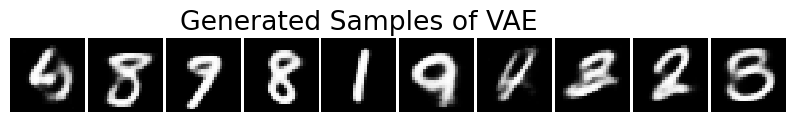

In [180]:
num_samples = 10
z = torch.randn(num_samples, latent_size).to(device=device)

VAE.eval()
samples = VAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    if i == 4:
      plt.title('Generated Samples of VAE')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='Greys_r')

# Conditional FC-VAE

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new digits randomly.

## Define Network with class input

Your CVAE architecture should be the same as your FC-VAE architecture, except you'll now concatenate a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space.

If the one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE_MLP` class use the same FC-VAE architecture implemented in the last network.


In [190]:
import torch
import torch.nn as nn

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        # Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Define layers for mean and log variance
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_classification = nn.Linear(hidden_dim, num_classes)

        # Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim + num_classes),
        )

    def reparameterize(self, mu, logvar):
        """Applies the reparameterization trick to sample z."""
        std = torch.exp(0.5 * logvar)  # Compute standard deviation
        eps = torch.randn_like(std)  # Random noise
        z = mu + eps * std  # Reparameterization trick
        return z

    def forward(self, x, y):
        """Implements the forward pass."""
        # Flatten the input and one-hot labels
        x = x.view(x.size(0), -1)  # Flatten the input data
        y = y.view(y.size(0), -1)  # Flatten the one-hot encoded labels

        # Concatenate x and y before passing them to the encoder
        xy = torch.cat([x, y], dim=1)

        # Encode input to get mu and logvar
        encoded = self.encoder(xy)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        encoder_classification = self.fc_classification(encoded)

        # Reparameterize to sample latent vector z
        z = self.reparameterize(mu, logvar)

        # Concatenate z and y before passing them to the decoder
        zy = torch.cat([z, y], dim=1)

        # Decode z and y to reconstruct the input
        output = self.decoder(zy)

        # Separate the output into reconstructed input and classification logits
        reconstructed = output[:, :input_dim]  # Assuming input_dim is the size of the input
        reconstructed = torch.sigmoid(reconstructed)  # Apply sigmoid for reconstruction
        decoder_classification = output[:, input_dim:]  # Remaining part for classification logits

        return reconstructed, mu, logvar, encoder_classification, decoder_classification

If you want to build helper functions, you can write the code in the below cell.

# Loss Function

Complete the cvae_loss function below

In [191]:
def cvae_loss(recon, data, mu, logvar, encoder_classification, decoder_classification, labels):
    """
    Computes the loss for the Conditional Variational Autoencoder.

    Args:
        recon (Tensor): The reconstructed output from the decoder.
        data (Tensor): The original input data.
        mu (Tensor): The mean vector from the encoder.
        logvar (Tensor): The log variance vector from the encoder.
        class_logits (Tensor): The predicted class logits from the encoder.
        labels (Tensor): The true labels (one-hot encoded or class indices).

    Returns:
        Tensor: The total loss as the sum of reconstruction, KL divergence, and cross-entropy losses.
    """
    # Flatten the data and recon tensors
    data = data.view(data.size(0), -1)
    recon = recon.view(recon.size(0), -1)

    # Reconstruction loss (binary cross-entropy for normalized inputs)
    recon_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    # KL divergence for a Gaussian is: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    cross_entropy_loss = F.cross_entropy(encoder_classification, labels, reduction='sum') + F.cross_entropy(decoder_classification, labels, reduction='sum')

    # Total loss
    total_loss = recon_loss + kl_loss + 0.5 * cross_entropy_loss

    return total_loss


## Train model

Using the same training script, let's now train our CVAE!



In [192]:
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []
        
        # Wrap train_loader with tqdm to show progress
        for batch_idx, (data, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
            # One-hot encode the labels
            labels_one_hot, labels = F.one_hot(labels, num_classes=10).float().to(device), labels.to(device)

            # Move data to the appropriate device
            data, labels_one_hot = data.to(device), labels_one_hot.to(device)

            # Forward pass through the model and calculate the loss
            recon, mu, logvar, encoder_classification, decoder_classification = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, encoder_classification, decoder_classification, labels)  # Modify as needed if class_logits are part of model

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())

        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f'CVAE-MLP Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}')

In [198]:
input_dim = 784  # Assuming flattened 28x28 images (e.g., MNIST)
hidden_dim = 256  # Example hidden size
latent_size = 8  # Example latent size
num_classes = 10  # Number of classes in dataset (e.g., MNIST)

# CVAE = CVAE_MLP(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_size, num_classes=num_classes)

# Assuming `loader_train` is a DataLoader for the training dataset
train_cvae_mlp(CVAE, loader_train, num_epochs=30, learning_rate=1e-4)

Epoch 1/30: 100%|██████████| 1875/1875 [00:10<00:00, 179.29it/s]


CVAE-MLP Epoch [1/30], Loss: 3151.847901041667



Epoch 2/30: 100%|██████████| 1875/1875 [00:10<00:00, 185.51it/s]


CVAE-MLP Epoch [2/30], Loss: 3136.7356100260417



Epoch 3/30: 100%|██████████| 1875/1875 [00:10<00:00, 181.88it/s]


CVAE-MLP Epoch [3/30], Loss: 3131.7331115885418



Epoch 4/30: 100%|██████████| 1875/1875 [00:10<00:00, 181.86it/s]


CVAE-MLP Epoch [4/30], Loss: 3127.3812239583335



Epoch 5/30: 100%|██████████| 1875/1875 [00:10<00:00, 180.77it/s]


CVAE-MLP Epoch [5/30], Loss: 3123.8271247395833



Epoch 6/30: 100%|██████████| 1875/1875 [00:10<00:00, 183.45it/s]


CVAE-MLP Epoch [6/30], Loss: 3120.11978125



Epoch 7/30: 100%|██████████| 1875/1875 [00:10<00:00, 176.94it/s]


CVAE-MLP Epoch [7/30], Loss: 3118.029006640625



Epoch 8/30: 100%|██████████| 1875/1875 [00:10<00:00, 183.47it/s]


CVAE-MLP Epoch [8/30], Loss: 3115.530525390625



Epoch 9/30: 100%|██████████| 1875/1875 [00:10<00:00, 180.50it/s]


CVAE-MLP Epoch [9/30], Loss: 3113.378397786458



Epoch 10/30: 100%|██████████| 1875/1875 [00:10<00:00, 177.80it/s]


CVAE-MLP Epoch [10/30], Loss: 3111.1554188802083



Epoch 11/30: 100%|██████████| 1875/1875 [00:10<00:00, 180.59it/s]


CVAE-MLP Epoch [11/30], Loss: 3109.2411953125



Epoch 12/30: 100%|██████████| 1875/1875 [00:10<00:00, 185.36it/s]


CVAE-MLP Epoch [12/30], Loss: 3107.10972734375



Epoch 13/30: 100%|██████████| 1875/1875 [00:10<00:00, 177.25it/s]


CVAE-MLP Epoch [13/30], Loss: 3105.12419765625



Epoch 14/30: 100%|██████████| 1875/1875 [00:10<00:00, 185.11it/s]


CVAE-MLP Epoch [14/30], Loss: 3103.6568736979166



Epoch 15/30: 100%|██████████| 1875/1875 [00:10<00:00, 184.53it/s]


CVAE-MLP Epoch [15/30], Loss: 3102.0710234375



Epoch 16/30: 100%|██████████| 1875/1875 [00:10<00:00, 183.37it/s]


CVAE-MLP Epoch [16/30], Loss: 3100.4296091145834



Epoch 17/30: 100%|██████████| 1875/1875 [00:09<00:00, 188.00it/s]


CVAE-MLP Epoch [17/30], Loss: 3098.1695364583334



Epoch 18/30: 100%|██████████| 1875/1875 [00:10<00:00, 186.52it/s]


CVAE-MLP Epoch [18/30], Loss: 3096.5626557291666



Epoch 19/30: 100%|██████████| 1875/1875 [00:10<00:00, 179.58it/s]


CVAE-MLP Epoch [19/30], Loss: 3095.1122704427084



Epoch 20/30: 100%|██████████| 1875/1875 [00:10<00:00, 186.13it/s]


CVAE-MLP Epoch [20/30], Loss: 3093.3524966145833



Epoch 21/30: 100%|██████████| 1875/1875 [00:10<00:00, 186.32it/s]


CVAE-MLP Epoch [21/30], Loss: 3092.204124739583



Epoch 22/30: 100%|██████████| 1875/1875 [00:10<00:00, 177.15it/s]


CVAE-MLP Epoch [22/30], Loss: 3091.451359375



Epoch 23/30: 100%|██████████| 1875/1875 [00:10<00:00, 180.34it/s]


CVAE-MLP Epoch [23/30], Loss: 3089.015018880208



Epoch 24/30: 100%|██████████| 1875/1875 [00:10<00:00, 179.50it/s]


CVAE-MLP Epoch [24/30], Loss: 3088.172841796875



Epoch 25/30: 100%|██████████| 1875/1875 [00:10<00:00, 179.64it/s]


CVAE-MLP Epoch [25/30], Loss: 3086.477859114583



Epoch 26/30: 100%|██████████| 1875/1875 [00:10<00:00, 183.21it/s]


CVAE-MLP Epoch [26/30], Loss: 3085.368367708333



Epoch 27/30: 100%|██████████| 1875/1875 [00:10<00:00, 184.40it/s]


CVAE-MLP Epoch [27/30], Loss: 3083.051869140625



Epoch 28/30: 100%|██████████| 1875/1875 [00:10<00:00, 179.54it/s]


CVAE-MLP Epoch [28/30], Loss: 3082.4592561197915



Epoch 29/30: 100%|██████████| 1875/1875 [00:09<00:00, 189.25it/s]


CVAE-MLP Epoch [29/30], Loss: 3080.8816584635415



Epoch 30/30: 100%|██████████| 1875/1875 [00:09<00:00, 188.15it/s]

CVAE-MLP Epoch [30/30], Loss: 3080.7426713541668


## Visualize Results

You've trained your CVAE, now let's conditionally generate some new data! This time, we can specify the class we want to generate by adding our one hot matrix of class labels. We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit. When you run the cell below, you should get one example per digit. Each digit should be reasonably distinguishable (it is ok to run this cell a few times to save your best results).



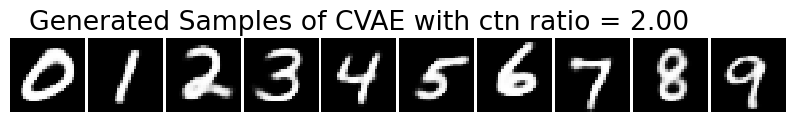

In [302]:
num_samples = 10
z = torch.randn(num_samples, latent_size)

condition_to_noise_ratio = 2
c = condition_to_noise_ratio * torch.eye(num_samples, 10)

z = torch.cat((z,c), dim=-1).to(device='cuda')
CVAE.eval()
samples = torch.sigmoid(CVAE.decoder(z)).data.cpu().numpy()[:, :784]

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    if i == 4:
      plt.title(f'Generated Samples of CVAE with ctn ratio = {condition_to_noise_ratio:.2f}')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

In [293]:
import numpy as np
import matplotlib.gridspec as gridspec
from PIL import Image

num_samples = 10
frames = []

start = 0.5
end = 12
num_points = 1200  # Total number of points

# Generate a non-linear range
linear_space = np.linspace(0, 1, num_points)
non_linear_range = start + (end - start) * linear_space**2

for j in non_linear_range:
    z = torch.randn(num_samples, latent_size)
    condition_to_noise_ratio = j
    c = condition_to_noise_ratio * torch.eye(num_samples, 10)

    z = torch.cat((z, c), dim=-1).to(device='cuda')
    CVAE.eval()
    samples = torch.sigmoid(CVAE.decoder(z)).data.cpu().numpy()[:, :784]

    fig = plt.figure(figsize=(num_samples, 2))  # Adjusted height to 2
    gspec = gridspec.GridSpec(1, num_samples)
    gspec.update(wspace=0.05, hspace=0.05)

    # Add a title for the whole figure
    fig.suptitle(f'Generated Samples of CVAE with ctn ratio = {j:.2f}', y=0.85, fontsize=15)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gspec[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    # Save the current figure as an image in memory
    plt.axis('off')
    fig.canvas.draw()
    img_array = np.array(fig.canvas.renderer.buffer_rgba())
    img_pil = Image.fromarray(img_array)
    frames.append(img_pil)

    plt.close(fig)  # Close the figure to avoid display

# Save the collected frames as a GIF
frames[0].save('gif.gif', save_all=True, append_images=frames[1:], duration=75, loop=0)


### Conditional Variational Autoencoder (C-VAE) and CTN Ratio

The **Condition-to-Noise (CTN) ratio** is a parameter in Conditional Variational Autoencoders (C-VAE) that governs the balance between the random noise and the conditioning signal in the latent space. This balance directly affects the diversity of the outputs generated by the model.

- **Low CTN Ratio:** When the CTN ratio is low, the random noise in the latent space has a stronger influence. This results in **high diversity** among the generated outputs, as the model incorporates significant randomness.

- **High CTN Ratio:** When the CTN ratio is high, the conditioning signal dominates. This makes the outputs more deterministic, as they align closely with the conditional input. However, this also means that the diversity of the outputs decreases, as the randomness from the noise is largely suppressed.

### Why Diversity Decreases with Increasing CTN Ratio

As the CTN ratio increases:
1. The model increasingly relies on the deterministic conditioning signal.
2. The contribution of noise to the latent representation becomes negligible.
3. The generated outputs become nearly identical for the same condition, reducing variability.

Conversely, at low CTN ratios, the noise component adds variability, allowing for a wider range of outputs even for the same condition.

### Visualization (GIF)

The GIF below demonstrates the effect of varying the CTN ratio:

- **Low Ratio:** At the start, the generated outputs exhibit high variability, reflecting the influence of random noise.
- **High Ratio:** As the CTN ratio increases, the outputs become more similar, showing a loss of diversity and increased determinism.

![CTN Ratio Effect on Diversity](gif.gif)

In the GIF, you can observe the transition from diverse to deterministic outputs as the CTN ratio progresses from low to high. This visualization highlights how the CTN ratio serves as a control for the diversity of the generated samples.